### Reproduce Figure 3 in Vecellio et al 2023

In [3]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from cartopy import config
from cartopy.io import shapereader
from geopy.geocoders import Nominatim
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [4]:
# read city information
CITIES=pd.read_excel('./data/CITIES.xlsx')

df=CITIES.copy()
drop_cities=['Jaipur','Ibadan','Hangzhou',"Xi'an",'Jinan']
for drop_city in drop_cities:
    drop_index=CITIES[CITIES['Cities'] == drop_city].index
    df=df.drop(labels=drop_index, axis=0)

In [17]:
def rename(data,name):
    data.name=name
    return data

# read global person-hothours with temperature>40C 
Tdb_lgt40_ssp2050=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_Tdb_lgt40.nc').hours*3).pipe(rename,'lgt40')
# read global person-hothours with temperature<40C 
Tdb_lst40_ssp2050=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_Tdb_lst40.nc').hours*3).pipe(rename,'lst40')
# read global total person-hothours
tot_ssp2050=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_tot.nc').hours*3).pipe(rename,'tot')
pophours=xr.merge([Tdb_lgt40_ssp2050,Tdb_lst40_ssp2050,tot_ssp2050])


# read person-hothours with temperature>40C for each region
Tdb_lgt40_region=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_Tdb_lgt40_regions.nc').hours*3).pipe(rename,'lgt40')
# read person-hothours with temperature<40C for each region
Tdb_lst40_region=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_Tdb_lst40_regions.nc').hours*3).pipe(rename,'lst40')
# read total person-hothours for each region
tot_region=(xr.open_dataset('./data/SSP_2050_pop_x_hothours_tot_regions.nc').hours*3).pipe(rename,'tot')
pophours_region=xr.merge([Tdb_lgt40_region,Tdb_lst40_region,tot_region])

In [18]:
def curve(x,y,axis,c,linestyle,label,marker,linewidth):
    g=axis.plot(x,y,color=c,linestyle=linestyle,label=label,marker=marker,linewidth=linewidth)
    return g

def plot(pophours,pophours_region):
    levels=[0,3,8,24,56,112,168,240,480,720]
    fig = plt.figure(figsize=(12,5.5))
    
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    
    anno_opts = dict(xy=(0.02, 0.90), xycoords='axes fraction',va='baseline', ha='left')
    annots=['a. Global','b. South Asia','c. East Asia','d. North Africa','e. Middle East','f. North America']
    region_names=['SAS','EAS','WAF','ME','NAM']
    for i in range(6):
        ax = fig.add_subplot(2,3,i+1)
        ax.annotate(annots[i], **anno_opts,fontsize=18)
        if i==0:
            curve(pophours.tot.mean('model').X.values,pophours.tot.mean('model').values/1e9,ax,'k','solid','Total','o',1.5)
            curve(pophours.lst40.mean('model').X.values,pophours.lst40.mean('model').values/1e9,ax,'b','solid','$T_a<40^\circ$C','o',1.5)
            curve(pophours.lgt40.mean('model').X.values,pophours.lgt40.mean('model').values/1e9,ax,'r','solid','$T_a>40^\circ$C','o',1.5)
            ax.fill_between(pophours.X.values,pophours.tot.quantile(0.1,dim='model').values/1e9,pophours.tot.quantile(0.9,dim='model').values/1e9,alpha=0.2,color='black')
            ax.legend(fontsize=12,loc='best')
        else:
            region_name=region_names[i-1]
            curve(pophours_region.tot.mean('model').X.values,pophours_region.tot.mean('model').sel(region=region_name).values/1e9,ax,'k','solid','Total','o',1.5)
            curve(pophours_region.lst40.mean('model').X.values,pophours_region.lst40.mean('model').sel(region=region_name).values/1e9,ax,'b','solid','$T_a<40^\circ$C','o',1.5)
            curve(pophours_region.lgt40.mean('model').X.values,pophours_region.lgt40.mean('model').sel(region=region_name).values/1e9,ax,'r','solid','$T_a>40^\circ$C','o',1.5)
            ax.fill_between(pophours_region.X.values,pophours_region.tot.sel(region=region_name).quantile(0.1,dim='model').values/1e9,pophours_region.tot.sel(region=region_name).quantile(0.9,dim='model').values/1e9,alpha=0.2,color='black')
    
        ax.set_xlim([0.97,4.03])
        ax.set_xlabel('')
        ax.set_ylabel('')
        if i >=3:
            ax.set_xticks([1,2,3,4])
        else:
            ax.set_xticks([])
        ax.tick_params(axis='both', which='major', labelsize=14)
        
    anno_opts_xlabel = dict(xy=(-1.35, -0.25), xycoords='axes fraction',va='baseline', ha='left')
    anno_opts_ylabel = dict(xy=(-1.55, -0.56), xycoords='axes fraction',va='baseline', ha='left')
    
    ylabel='person-hours (billions)'
    xlabel='Global warming target ($^\circ$C)'
    axs=fig.get_axes()
    axs[4].annotate(xlabel, **anno_opts_xlabel,fontsize=20)
    axs[0].annotate(ylabel, **anno_opts_ylabel,fontsize=20,rotation=90)
    fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0.,wspace=0.25)  

<ipython-input-18-0d525e3a5222>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,3,i+1)
<ipython-input-18-0d525e3a5222>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,3,i+1)
<ipython-input-18-0d525e3a5222>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

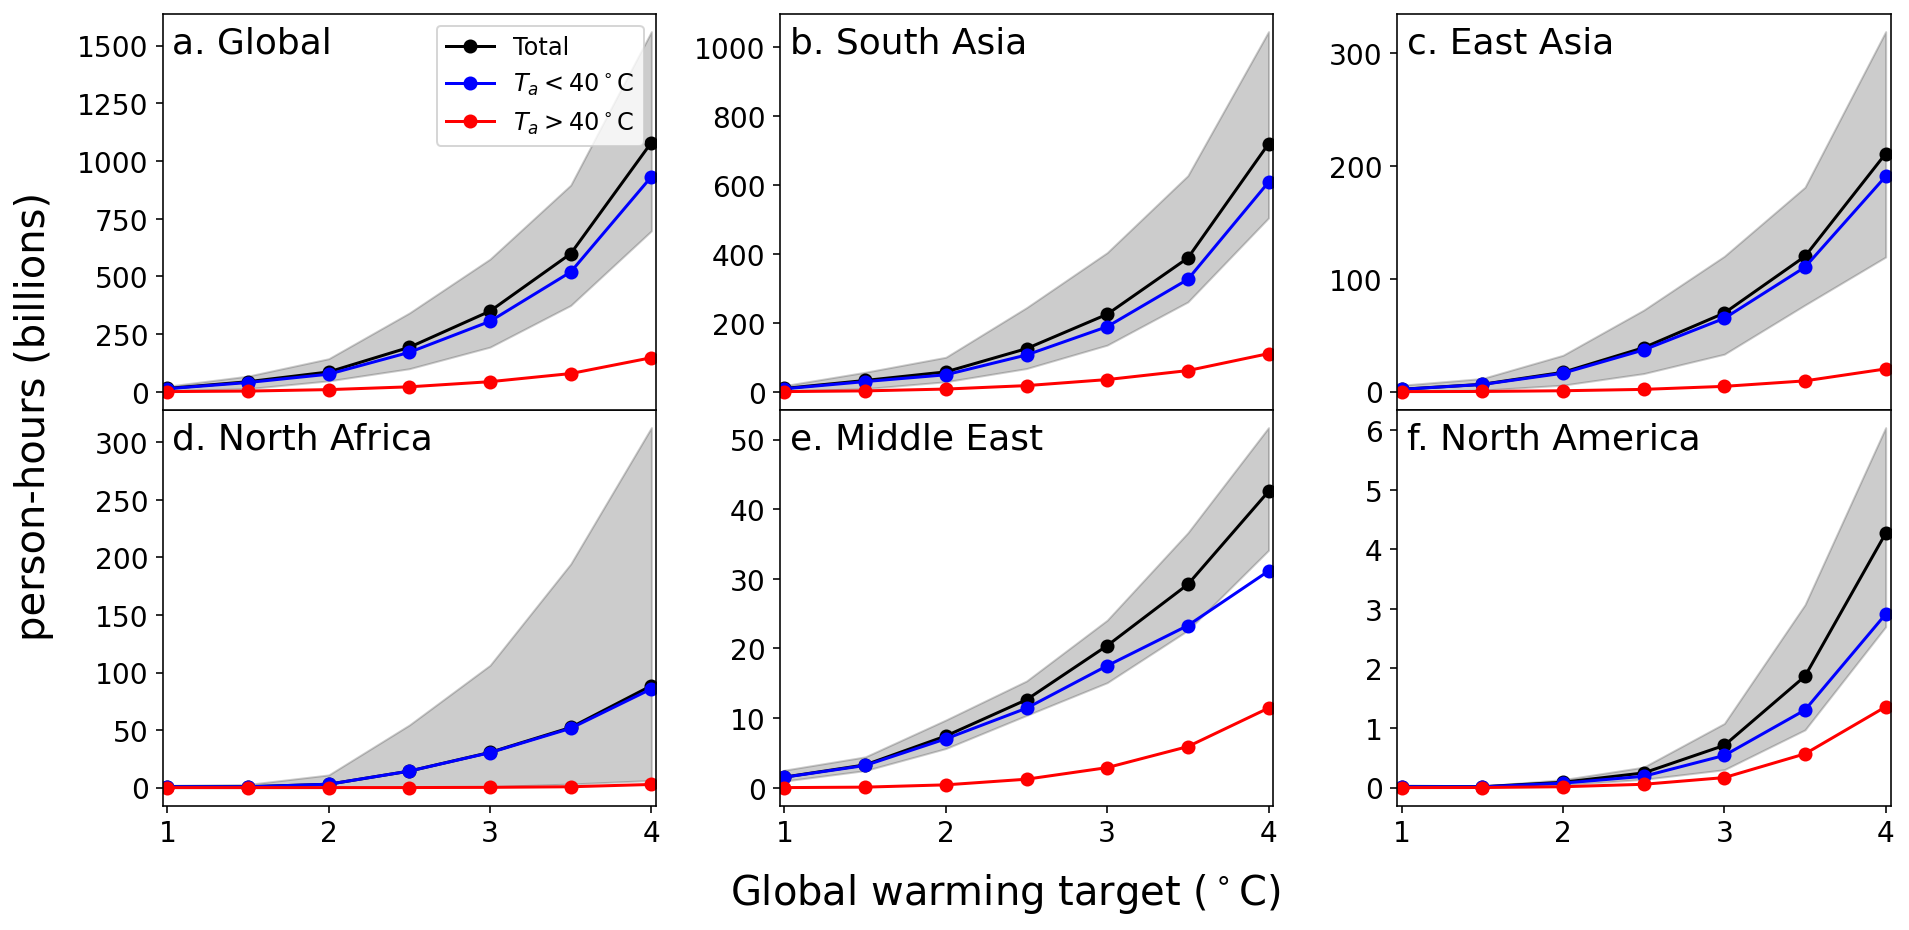

In [19]:
plot(pophours,pophours_region)